<a href="https://colab.research.google.com/github/flatneuron/image_processing/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
!pip install gdown

In [2]:
import gdown
import os

#function to download input videos from gdrive
def download_file_from_google_drive(file_id, output_filename):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, output_filename, quiet=False)
    print(f"Downloaded {output_filename}")

In [3]:
download_file_from_google_drive('1vkjDMtIaeFzJ0-xeh90IShzsNJSoR5i9', 'task1_input_video.mp4') # input video for task 1
download_file_from_google_drive('1BO9q8ujit3SBj236IyAJ87phHGsoqqn7', 'task2_input_video.mp4') # input video for task 2

Downloading...
From: https://drive.google.com/uc?id=1vkjDMtIaeFzJ0-xeh90IShzsNJSoR5i9
To: /content/task1_input_video.mp4
100%|██████████| 47.5M/47.5M [00:00<00:00, 97.0MB/s]


Downloaded task1_input_video.mp4


Downloading...
From: https://drive.google.com/uc?id=1BO9q8ujit3SBj236IyAJ87phHGsoqqn7
To: /content/task2_input_video.mp4
100%|██████████| 887k/887k [00:00<00:00, 9.69MB/s]

Downloaded task2_input_video.mp4


In [4]:
# downloading required libraries for task 1 and task 2
!pip install ultralytics opencv-python pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

#Task *1* : Detection Summary Engine

In [5]:
# this will output 5 things
#   1. task1_detection_results.json : it contains the object class , bounding box and confidence of every object in the frame (every 5th frame)
#   2. task1_frame_summary.csv: it contains the frame index, total no. of objects and no. of unique objects in each frame.
#   3. task1_annotated_frames: it contains the frames with bounding box and labels drawn over each frame.
#   4. at the end of this section ,it prints the frame_index with maximum class diversity(maximum no. of unique classes) and no. of classes in it.
#   5. at the end of this section ,there is a graph that shows the total frequency of classes in all the frames (every 5th frame in our case).

In [6]:
from ultralytics import YOLO
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

# Load model
model = YOLO('yolo11m.pt')

# Video setup
video_path = 'task1_input_video.mp4'
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
step = 5

# Outputs
results_json = [] # to store the result.json
summary_rows = [] # for total no. of object and no. of unique objects in frame
class_counter = {} # to keep the count of class they appeared in frames
diversity_per_frame = {} # unique class in each frame

# Annotated output directory
os.makedirs('task1_annotated_frames', exist_ok=True)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 38.8M/38.8M [00:00<00:00, 124MB/s]


In [14]:
# Iterating over the video capturing annotation every 5th frame
frame_idx = 0
while cap.isOpened() :
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % step == 0:
        res = model(frame)[0] # run model over the frame and get results in res
        detections = []
        class_set = set()

        for box in res.boxes:
            cls_id = int(box.cls.cpu().numpy()[0]) # gets class id in numeric
            cls_name = model.names[cls_id] # gets class name from class id
            x1, y1, x2, y2 = box.xyxy.cpu().numpy().tolist()[0] # gets coordinates of bounding box
            conf = float(box.conf.cpu().numpy()[0]) # confidence of model on each object to which class it predicted

            detections.append({
                'class': cls_name,
                'bbox': [x1, y1, x2, y2],
                'confidence': conf
            })
            class_counter[cls_name] = class_counter.get(cls_name, 0) + 1

            class_set.add(cls_name)

        # Frame-level summary row
        summary_rows.append({
            'frame': frame_idx,
            'total_objects': len(detections),
            'unique_classes_count': len(class_set)
        })

        diversity_per_frame[frame_idx] = len(class_set)

        # Store full detection for this frame
        results_json.append({
            'frame': frame_idx,
            'detections': detections
        })

        # Save annotated frame
        annotated = res.plot()
        cv2.imwrite(f'task1_annotated_frames/frame_{frame_idx:04d}.jpg', annotated)

    frame_idx += 1

cap.release()

# Save full detection result JSON
with open('task1_detection_results.json', 'w') as f:
    json.dump(results_json, f, indent=2)

In [8]:
# Save frame summary CSV
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv('task1_frame_summary.csv', index=False)
print("frame summary")
print(summary_df.head())

frame summary
   frame  total_objects  unique_classes_count
0      0             11                     2
1      5             11                     3
2     10             12                     3
3     15             12                     3
4     20             10                     2


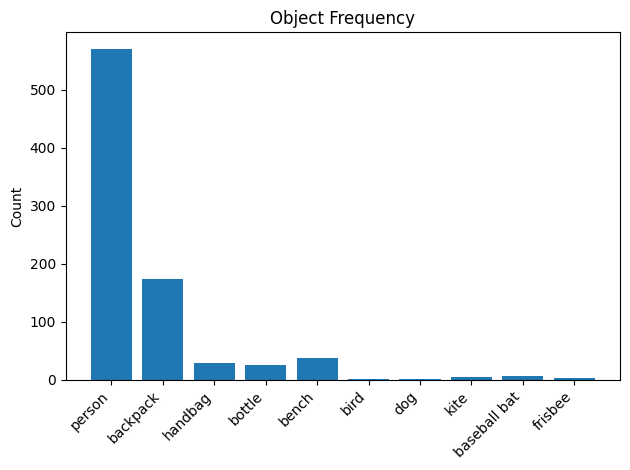

Frame index with max class diversity: 235 (5 classes)


In [9]:
# plot total object frequencies over all frames annotated
plt.figure()
plt.bar(class_counter.keys(), class_counter.values())
plt.title('Object Frequency')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Frame with max diversity
max_div_frame = max(diversity_per_frame, key=diversity_per_frame.get)
print(f"Frame index with max class diversity: {max_div_frame} ({diversity_per_frame[max_div_frame]} classes)")

#Task 2 : Real-Time Stream Simulation & Event Trigger

In [10]:
# This will output 3 things
#   1. task2_alert_log.txt : it contains the frame no. when the alert triggers also this is also printed in the terminal when it happens.
#      (condition for alert: when processing every 3rd frame from the video stream we get 5 consecutive frames having people 3 or more in each)
#   2. task2_annotated_frames_for_crowd: the annotated frames folder with bounding box and class label over each object in the frame
#      and a text saying (crowd alert) if alert triggers over that frame.
#   3. a graph in the end showing the alert triggers over the frame index.

In [11]:
video_path = 'task2_input_video.mp4'
os.makedirs('task2_annotated_frames_for_crowd', exist_ok=True)


# Alert variables
crowd_alert_threshold = 3  # this variable is for no. of people greater than equal to to be considered crowd
consecutive_frames_threshold = 5 # no. of conseccutive frames equal to or over which alert triggers
alert_log = [] # to log the alert messages to be later written into disk
consecutive_crowd_frames = 0 # keeps count of consecutive frames over which crowd is detected
alert_active = False # turns true if alert triggers


Crowd Detected at frame 117
Crowd Detected at frame 120
Crowd Detected at frame 123
Crowd Detected at frame 144
Crowd Detected at frame 147
Crowd Detected at frame 150
Crowd Detected at frame 153
Crowd Detected at frame 156
Crowd Detected at frame 159
Crowd Detected at frame 162
Crowd Detected at frame 165
Crowd Detected at frame 168
Crowd Detected at frame 171
Crowd Detected at frame 174
Crowd Detected at frame 177
Crowd Detected at frame 180
Crowd Detected at frame 183
Crowd Detected at frame 186
Crowd Detected at frame 189
Crowd Detected at frame 192
Crowd Detected at frame 195
Crowd Detected at frame 198
Crowd Detected at frame 201
Crowd Detected at frame 204
Crowd Detected at frame 207
Crowd Detected at frame 210
Crowd Detected at frame 213
Crowd Detected at frame 216
Crowd Detected at frame 219
Crowd Detected at frame 222
Crowd Detected at frame 225
Crowd Detected at frame 228
Crowd Detected at frame 231
Crowd Detected at frame 234
Crowd Detected at frame 237
Crowd Detected at fr

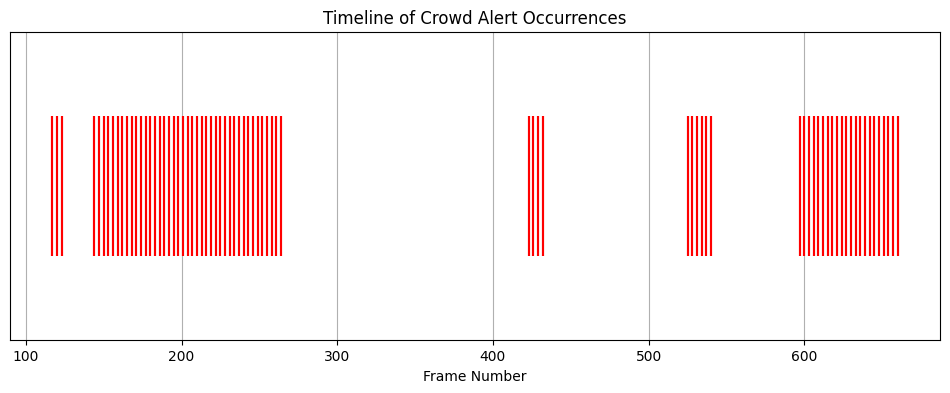

In [15]:

# Frame index restart
frame_idx = 0
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Simulate processing every 3rd frame
    if frame_idx % 3 == 0:
        results = model(frame)[0]

        # Process detection results
        people_count = 0
        for r in results:
            for c in r.boxes.cls:
                if model.names[int(c)] == 'person':
                    people_count += 1


        # Check for crowd alert condition
        current_frame_is_crowd = people_count >= crowd_alert_threshold

        if current_frame_is_crowd:
            consecutive_crowd_frames += 1
        else:
            consecutive_crowd_frames = 0 # Reset if the current frame doesn't meet the threshold

        # Trigger alert based on consecutive frames
        if consecutive_crowd_frames >= consecutive_frames_threshold :
            alert_message = f"Crowd Detected at frame {frame_idx}"
            print(alert_message)
            alert_log.append({'frame': frame_idx, 'alert': alert_message})
            alert_active = True # Set alert as active to prevent multiple logs for the same continuous event
        elif consecutive_crowd_frames < consecutive_frames_threshold and alert_active:
             # If a crowd alert was active and the consecutive count drops below the threshold
             # it means the crowd event has ended. You can log an "End of Crowd" event here if needed.
             # For this task, we only log the start of a crowd event.
             alert_active = False

        annotated = results.plot()
        # Overlay alert text on the frame
        if alert_active:
             cv2.putText(annotated, "Crowd Alert!", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
             cv2.imwrite(f'task2_annotated_frames_for_crowd/frame_{frame_idx:04d}_alert.jpg', annotated) # save frame with alert message
        elif frame_idx % step != 0: # Save frame without alert message
             cv2.imwrite(f'task2_annotated_frames_for_crowd/frame_{frame_idx:04d}.jpg', annotated)


    frame_idx += 1

cap.release()

# Log alerts to a text file
with open('task2_alert_log.txt', 'w') as f:
    for entry in alert_log:
        f.write(f"Frame {entry['frame']}: {entry['alert']}\n")

# Plot timeline of alert occurrences
if alert_log:
    alert_frames = [entry['frame'] for entry in alert_log]
    plt.figure(figsize=(12, 4))
    plt.eventplot(alert_frames, orientation='horizontal', colors='r')
    plt.title('Timeline of Crowd Alert Occurrences')
    plt.xlabel('Frame Number')
    plt.yticks([]) # Hide y-axis ticks
    plt.grid(axis='x')
    plt.show()
else:
    print("No alerts were triggered.")